# HW4: QA Agent

## Dependencies and LLM Backbone

In [1]:
# !pip install langchain==1.0.5
# !pip install langchain-core
# !pip install langchain-community
# !pip install faiss-cpu
# !pip install kagglehub
# !Install DuckDuckGo search dependency
# !pip install -U ddgs
device = "cuda"  # "cpu" or "cuda"

In [2]:
# This is the list of countries we are using (with their official languages)
# Feel free to use it in your code
list_of_countries = {}
with open("countries_with_languages.tsv", "r"  ) as f:
    for line in f.readlines():
        country, langs = line.strip().split("\t")
        list_of_countries[country] = langs.split(",")

### Choice 1: OpenAI API

The notebook's implementation is based on this.
Feel free to change the model, and please keep track of your usage on the "Usage" page on [LiteLLM API webpage](https://ai-gateway.andrew.cmu.edu/ui/).

In [3]:
# !pip install langchain-openai

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import getpass, os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")
openai_model_id = "gpt-5"
openai_embmodel_id = "azure/text-embedding-3-small"

llm = ChatOpenAI(
    model=openai_model_id,
    api_key=os.environ["OPENAI_API_KEY"],
    base_url="https://ai-gateway.andrew.cmu.edu/"
)
embeddings = OpenAIEmbeddings(
    model=openai_embmodel_id,
    api_key=os.environ['OPENAI_API_KEY'],
    base_url='https://ai-gateway.andrew.cmu.edu/'
)

### Choice 2: Hugging Face Models

You may also use Hugging Face models without API credits if you have available GPU resource. You might have to the change prompt templates according to your model choice.

In [5]:
# !pip install langchain-huggingface text-generation transformers google-search-results 
# !pip install numexpr langchainhub sentencepiece sentence-transformers jinja2 bitsandbytes accelerate

In [ ]:
import getpass, os
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline, HuggingFaceEmbeddings

os.environ["HUGGINGFACEHUB_API_TOKEN"] = getpass.getpass("Enter your Hugging Face API key: ")
hgf_model_id = "Qwen/Qwen3-0.6B"
hgf_embmodel_id = "sentence-transformers/all-mpnet-base-v2"

hgf_model = HuggingFacePipeline.from_model_id(
    model_id=hgf_model_id,
    task="text-generation",
    pipeline_kwargs=dict(
        max_new_tokens=128,
        do_sample=False,
    ),
)
hgf_llm = ChatHuggingFace(hgf_model)
hgf_embeddings = HuggingFaceEmbeddings(model_name=hgf_embmodel_id)

## Handling different type of questions

Implement the answer formatting and extraction for each question type. You may change the prompt to fit your processing function.

In [7]:
from langchain.agents import create_agent

### 🗺️Global Trekker

In [ ]:
from langchain.tools import tool

@tool
def web_search(query: str) -> str:
    """
    Searches the web for information about locations, landmarks, and geographic features.
    Useful for identifying cities and countries from descriptive clues.
    """
    try:
        from langchain_community.tools import DuckDuckGoSearchRun
        search = DuckDuckGoSearchRun()
        try:
            results = search.run(query)
            return results
        except Exception as e:
            return f"Search error: {str(e)}"
    except Exception as e:
        return (
            "DuckDuckGo search dependency missing or failed to load. "
            "Install with: pip install -U ddgs. Error: " + str(e)
        )

In [9]:
global_trekker_messages = [
    {"role": "system", "content": "You are an expert in world geography and cultural geography. Given a descriptive paragraph, infer the most likely country and city with high precision."},
    {"role": "user", "content": """
Read the paragraph and extract:
- Country: use the full official country name (e.g., "United States", not "USA").
- City: a specific city if clearly indicated by clues (landmarks, neighborhoods, transit lines, local foods, dialects). If not identifiable, write "Unknown".

Strict output format (no explanations):
[Country], [City]

Guidelines:
- Prefer unique cues (local transit names, street names, postal formats, phone codes, currency, cuisine, sports clubs).
- If multiple cities fit, pick the single most likely one.
- If the paragraph is generic or only country-level, return "Unknown" for city.
- Do not include any extra text besides the bracketed pair.

Examples:
Input: "We walked along the Arno past the Ponte Vecchio before climbing to Piazzale Michelangelo."
Output: [Italy], [Florence]

Input: "A red double-decker bus passed by the Thames near Westminster Abbey and Big Ben."
Output: [United Kingdom], [London]

Input: "We grabbed Primanti's near the confluence of the Allegheny and Monongahela."
Output: [United States], [Pittsburgh]

Input: "I toured the Old Town and the Royal Mile before seeing the castle on the hill."
Output: [United Kingdom], [Edinburgh]

Input: "We enjoyed maple syrup and poutine while skating on a canal in winter."
Output: [Canada], [Ottawa]
"""},
]
global_trekker = create_agent(model=llm, tools=[])

In [ ]:
def extract_global_trekker_answer(response: str) -> tuple[str, str]:
    # TODO: Extract the country and city from the response
    # return country, city
    import re
    
    chars = r'\[([^\]]+)\]\s*,\s*\[([^\]]+)\]'
    match = re.search(chars, response)
    
    if match:
        country = match.group(1).strip()
        city = match.group(2).strip()
        return country, city
    
    lines = response.strip().split('\n')
    for line in lines:
        if len(line) > 100:
            continue
        if ',' in line:
            parts = line.split(',')
            if len(parts) >= 2:
                country = parts[0].strip().strip('[]"\'')
                city = parts[1].strip().strip('[]"\'')
                for prefix in ['The answer is', 'Answer:', 'Location:', 'Country:', 'City:']:
                    country = country.replace(prefix, '').strip()
                    city = city.replace(prefix, '').strip()
                return country, city
    
    return "", ""

In [11]:
# Test run your extration function before using it in the main loop!
extract_global_trekker_answer("AAA, BBB")

('AAA', 'BBB')

### 🍽️Culinary Detective

In [ ]:
import kagglehub
import pandas as pd

def gather_recipe_data(kaggledataset: str) -> list[str]:
    dataset_path = kagglehub.dataset_download(kaggledataset)
    df = pd.read_csv(f"{dataset_path}/Receipes from around the world.csv", encoding='latin-1')
    
    recipes = []
    for _, row in df.iterrows():
        recipe_parts = []
        for col in df.columns:
            value = row[col]
            if pd.notna(value) and str(value).strip():
                recipe_parts.append(f"{col}: {value}")
        
        recipe_text = ". ".join(recipe_parts)
        recipes.append(recipe_text)
    
    return recipes

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain.tools import tool

recipes = gather_recipe_data("prajwaldongre/collection-of-recipes-around-the-world")
docs = [Document(page_content=recipe) for recipe in recipes]
vector = FAISS.from_documents(docs, embeddings)
retriever = vector.as_retriever(search_kwargs={"k": 2})

## RAG Tool
I created the following:
- a folder to store embeddings and faiss index
- a rag pipeline file
- a file that exposes the rag pipeline as a tool. 
- I am importing the tool in here. 

In [ ]:
from langchain.tools import tool
from rag_system.rag_pipeline import CulinaryRAG

rag = CulinaryRAG()
retriever = rag.load_index() 

@tool
def retrieve_culinary_context(query: str):
    """
    Retrieves culinary information relevant to country/region origin detection.
    Takes a descriptive query (ingredients, cooking method, spices) and performs vector retrieval.
    """
    docs = retriever.invoke(query)
    return "\n".join([d.page_content for d in docs])

/home/sagemaker-user/codespace/nlp_assignments/improved_qa_agents/rag_system/rag_pipeline.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(
2025-12-06 10:15:18.336970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765016118.365881   55052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765016118.377381   55052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register f

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prajwaldongre/collection-of-recipes-around-the-world")

print("Path to dataset files:", path)

Path to dataset files: /home/sagemaker-user/.cache/kagglehub/datasets/prajwaldongre/collection-of-recipes-around-the-world/versions/1


In [16]:
@tool
def retrieve_recipes(query: str):
  """
  Retrieves recipes based on a search query.
  """
  return retriever.invoke(query)

culinary_detective_messages = [
    {"role": "system", "content": """
You are an expert culinary anthropologist. From ingredients and a short description, identify the country and the SPECIFIC region within that country where the dish is most associated.

You can consult a retrieval tool bound to this agent (retrieve_culinary_context). Use it when helpful; otherwise reason from your knowledge of ingredients, techniques, and named dishes.
"""},
    {"role": "human", "content": """
Task:
Return ONLY a single line in the exact format: [Country], [Region]
- Country: full official name (e.g., "United States", not "USA").
- Region: a specific intra-country region (e.g., North, South, East, West, Central, Northeast, etc.).
- Use "All" only if the dish is truly nationwide.
- If no region is identifiable, write "Unknown".
- Do NOT include any explanation before or after the bracketed answer.

Cues to consider:
- Ingredients (grains, staple flours, spice blends), cooking methods, named dishes, iconic sides.
- Example mappings:
  * Brazil: pão de queijo / tapioca flour / queijo minas → [Brazil], [South]
  * Japan: sushi / rice vinegar / tempura → [Japan], [All]
  * India: dosa / idli / coconut → [India], [South]; naan / paneer / tandoor → [India], [North]
  * Ethiopia: teff / injera / wat / berbere → [Ethiopia], [Unknown]
  * China: dim sum → [China], [South]; hot pot (Sichuan/Chongqing-style) → [China], [West]
  * Thailand: khao soi → [Thailand], [North]; som tam → [Thailand], [Northeast]

Few-shot examples:
Input: "Fermented teff flatbread served with spicy stews (wat) and berbere."
Output: [Ethiopia], [Unknown]

Input: "Cheese bread made with tapioca starch, typical with churrasco in the south."
Output: [Brazil], [South]

Input: "Batter of rice and urad dal, steamed into soft cakes, served with coconut chutney."
Output: [India], [South]

Input: "Assorted small bites with tea in bamboo steamers, hallmark of Cantonese cuisine."
Output: [China], [South]

Now produce ONLY the answer for the current input as [Country], [Region].
"""},
]

culinary_detective = create_agent(model=llm, tools=[retrieve_culinary_context])

In [17]:
result = culinary_detective.invoke({
    "messages": culinary_detective_messages + [
        {"role": "human", "content": "The dish is spicy, coconut-based, and served with rice."}
    ]
})
print(result)

{'messages': [SystemMessage(content='\nYou are an expert culinary anthropologist. From ingredients and a short description, identify the country and the SPECIFIC region within that country where the dish is most associated.\n\nYou can consult a retrieval tool bound to this agent (retrieve_culinary_context). Use it when helpful; otherwise reason from your knowledge of ingredients, techniques, and named dishes.\n', additional_kwargs={}, response_metadata={}, id='26472349-a4d7-4947-8ad4-b04953455e00'), HumanMessage(content='\nTask:\nReturn ONLY a single line in the exact format: [Country], [Region]\n- Country: full official name (e.g., "United States", not "USA").\n- Region: a specific intra-country region (e.g., North, South, East, West, Central, Northeast, etc.).\n- Use "All" only if the dish is truly nationwide.\n- If no region is identifiable, write "Unknown".\n- Do NOT include any explanation before or after the bracketed answer.\n\nCues to consider:\n- Ingredients (grains, staple fl

In [18]:
def extract_culinary_detective_answer(response: str) -> tuple[str, str]:
    # TODO: Extract the country and region from the response
    # return country, region
    import re
    
    chars = r'\[([^\]]+)\]\s*,\s*\[([^\]]+)\]'
    match = re.search(chars, response)
    
    if match:
        country = match.group(1).strip()
        region = match.group(2).strip()
        return country, region
    
    lines_split = response.strip().split('\n')
    for line in lines_split:
        if len(line) > 100:
            continue
        if ',' in line:
            parts = line.split(',')
            if len(parts) >= 2:
                country = parts[0].strip().strip('[]"\'')
                region = parts[1].strip().strip('[]"\'')
                for prefix in ['The answer is', 'Answer:', 'Country:', 'Region:']:
                    country = country.replace(prefix, '').strip()
                    region = region.replace(prefix, '').strip()
                return country, region
    
    return "", ""

In [19]:
# extract_culinary_detective_answer(result)

### 👄Lingua Locale

In [33]:
lingua_locale_messages = [
    {"role": "system", "content": """
You are an expert in languages, scripts, orthography, and regional vocabulary. Determine which country's website or text a sentence most likely comes from.
"""},
    {"role": "user", "content": """
You must ONLY return a single line: [Country]. You should use the full official country name (e.g., "United States", not "USA"). 
- You should not add any other explanations. Only output the name of the country.
"""},
]

lingua_locale = create_agent(model=llm, tools=[])

In [34]:
def extract_lingua_locale_answer(response: str) -> tuple[str, str]:
    # TODO: Extract the country and "none" from the response
    # only the first field is used, the second is a dummy field to make the return type consistent
    # return country, "none"
    import re
    
    chars = r'\[([^\]]+)\]'
    match = re.search(chars, response)
    
    if match:
        country = match.group(1).strip()
        return country, "none"
    
    lines_split = response.strip().split('\n')
    for line in lines_split:
        if len(line) > 100:
            continue
        clean_line = line.strip().strip('[]"\'')
        for prefix in ['The answer is', 'Answer:', 'Country:', 'The country is', 'This is from']:
            clean_line = clean_line.replace(prefix, '').strip()
        
        if clean_line and len(clean_line) < 50:
            clean_line = clean_line.rstrip('.,;:')
            return clean_line, "none"
    
    return "", "none"

## Answering questions
This part includes how we load the questions and generate the prediction in desired format. 

In [35]:
def geoguesser(q: dict, print_raw_response=False) -> tuple[str, str]:
    if q["type"] == "GlobalTrekker":
        query = {"role": "user", "content": f"Paragraph: {q['paragraph']}"}
        messages, agent, extractor = global_trekker_messages, global_trekker, extract_global_trekker_answer
    elif q["type"] == "CulinaryDetective":
        query = {"role": "user", "content": f"Ingredients: {q['ingredient']}. Description: {q['description']}"}
        messages, agent, extractor = culinary_detective_messages, culinary_detective, extract_culinary_detective_answer
    else: #q["type"] == "LinguaLocale":
        query = {"role": "user", "content": f"Sentence: {q['sentence']}"}
        messages, agent, extractor = lingua_locale_messages, lingua_locale, extract_lingua_locale_answer

    response_all = agent.invoke({"messages": messages + [query]})
    response = response_all["messages"][-1].content
    if print_raw_response: print(f"{q['type']}: {response_all}")
    return extractor(response)

In [36]:
import json

# Here, we load the examples questions. Public/private set will be in the same format
dataset_name = "private.jsonl"
questions = []
with open(dataset_name, "r") as f:
    for line in f.readlines():
        questions.append(json.loads(line))

In [37]:
# Test run on one question
# You might want to save the raw response for debugging answer formatting/extraction
# If the extracted answer seems off, check the raw response instead of running inference repeatedly
geoguesser(questions[0], print_raw_response=True)

LinguaLocale: {'messages': [SystemMessage(content="\nYou are an expert in languages, scripts, orthography, and regional vocabulary. Determine which country's website or text a sentence most likely comes from.\n", additional_kwargs={}, response_metadata={}, id='eb91a6d1-a4ee-476e-a1cc-a170f4a5dda2'), HumanMessage(content='\nYou must ONLY return a single line: [Country]. You should use the full official country name (e.g., "United States", not "USA"). \n- You should not add any other explanations. Only output the name of the country.\n', additional_kwargs={}, response_metadata={}, id='56e3d8b6-a207-462f-b894-620142af5380'), HumanMessage(content='Sentence: No zwee Joer Iwwerleeungen, Diskussiounen, Debaten, Dialogen, Diagnosen a Consultatiounen ass de Plang konkretiséiert ginn.', additional_kwargs={}, response_metadata={}, id='b7211937-c28a-4e81-9881-cc2b254daddb'), AIMessage(content='Luxembourg', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens':

('Luxembourg', 'none')

In [38]:
# Sample script to generate answers
from tqdm import tqdm
answers = []
for q in tqdm(questions):
    try:
        country, category = geoguesser(q)
        answers.append(f"{q['type']}\t{country}\t{category}")
    except Exception as e:
        print(f"Error processing question {q}: {e}")
        answers.append(f"{q['type']}\tUnknown\tUnknown")

with open("private.txt", "w") as f:
    for answer in answers:
        f.write(answer + "\n")

print("Saved predictions to public.txt (private set)")

  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 174/174 [23:13<00:00,  8.01s/it]

Saved predictions to public.txt (private set)


## Evaluation
This is how we calculate the scores on Gradescope (details subject to change, but the general logic will stay the same).

In [26]:
def soft_match(answer, expectedAnswer):
    score = 0.0
    if expectedAnswer in answer:
        score = len(expectedAnswer) / len(answer)
    return score

def exact_match(answer, expectedAnswer):
    score = 0.0
    if expectedAnswer == answer:
        score = 1.0
    return score    

In [ ]:
answers = []
for q in questions:
    answers.append((q["type"], q["country"], q.get("city", q.get("region", ""))))
with open("public.txt", "r") as f:
    preds = [line.split("\t") for line in f.readlines()]

scores = {"GlobalTrekker": [], "CulinaryDetective": [], "LinguaLocale": []}
for (q_type, exp_country, exp_place), (p_type, pred_country, pred_place) in zip(answers, preds):
    assert q_type == p_type
    country_score = soft_match(pred_country, exp_country)
    category_score = 0.0
    weights = [0.0, 0.0]
    if q_type == "GlobalTrekker":
        #  correct country -> 80%, correct country and city -> +20%
        weights = [0.8, 0.2]
        if country_score > 0:
            if exp_place == "None": category_score = 1.0
            else: category_score = soft_match(pred_place, exp_place)
    elif q_type == "CulinaryDetective":
        # correct country -> 60%, correct country and region -> +40%
        weights = [0.6, 0.4]
        if country_score > 0:
            if exp_place == "None": category_score = 1.0
            else: category_score = exact_match(pred_place, exp_place)
    else: # LinguaLocale
        # correct country -> 60%, matched official language -> +40%
        weights = [0.6, 0.4]
        if country_score > 0:
            category_score = 1.0
        else: # incorrect country. language match works only if pred_country is a clean answer
            exp_langs = list_of_countries.get(exp_country, [])
            pred_langs = list_of_countries.get(pred_country, [])
            if any(lang in exp_langs for lang in pred_langs):
                category_score = 1.0

    score = weights[0] * country_score + weights[1] * category_score
    scores[q_type].append(score)

for q_type, score_list in scores.items():
    avg_score = sum(score_list) / len(score_list)
    print(f"{q_type} Average Score: {avg_score:.4f}")

GlobalTrekker Average Score: 0.8470
CulinaryDetective Average Score: 0.5345
LinguaLocale Average Score: 0.9329


In [11]:
# -----------------------------
# 1. IMPORT REQUIRED LIBRARIES
# -----------------------------
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

# -----------------------------
# 2. PARSE GROUND-TRUTH LABELS
# -----------------------------
true_task_list = []
true_country_list = []
true_region_list = []

with open("public.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        
        task = obj["type"]
        country = obj["country"]

        # Region logic depends on task type
        if task == "GlobalTrekker":
            region = obj.get("city", "")
        elif task == "CulinaryDetective":
            region = obj.get("region", "")
        else:  # LinguaLocale
            region = ""

        true_task_list.append(task)
        true_country_list.append(country)
        true_region_list.append(region)

print("Loaded GT samples:", len(true_task_list))


# -----------------------------
# 3. PARSE MODEL PREDICTIONS
# -----------------------------
pred_task_list = []
pred_country_list = []
pred_region_list = []

with open("public.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 3:
            parts += [""] * (3 - len(parts))

        t, c, r = parts[:3]
        pred_task_list.append(t)
        pred_country_list.append(c)
        pred_region_list.append(r)

print("Loaded prediction samples:", len(pred_task_list))


# -----------------------------
# 4. VALIDATE LENGTHS
# -----------------------------
assert len(true_task_list) == len(pred_task_list), \
    "ERROR: Prediction count does not match ground truth count!"

print("Validation passed!")


Loaded GT samples: 170
Loaded prediction samples: 170
Validation passed!


In [22]:
country_acc = accuracy_score(true_country_list, pred_country_list)
print("Country Accuracy:", country_acc)

country_macro_f1 = f1_score(true_country_list, pred_country_list, average="macro")
print("Country Macro F1:", country_macro_f1)

country_micro_f1 = f1_score(true_country_list, pred_country_list, average="micro")
print("Country Micro F1:", country_micro_f1)

region_country_acc = accuracy_score(true_region_list, pred_region_list)
print("Country Region Accuracy:", region_country_acc)

region_macro_f1 = f1_score(true_region_list, pred_region_list, average="macro")
print("Region Macro F1:", region_macro_f1)

region_micro_f1 = f1_score(true_region_list, pred_region_list, average="micro")
print("Region Micro F1:", region_micro_f1)

exact_match = np.mean([
    (true_country_list[i] == pred_country_list[i]) and
    (true_region_list[i]  == pred_region_list[i])
    for i in range(len(true_country_list))
])

print("Exact Match: ", exact_match)



Country Accuracy: 0.9058823529411765
Country Macro F1: 0.7723229291716687
Country Micro F1: 0.9058823529411765
Country Region Accuracy: 0.36470588235294116
Region Macro F1: 0.4893387096295568
Region Micro F1: 0.36470588235294116
Exact Match:  0.3352941176470588


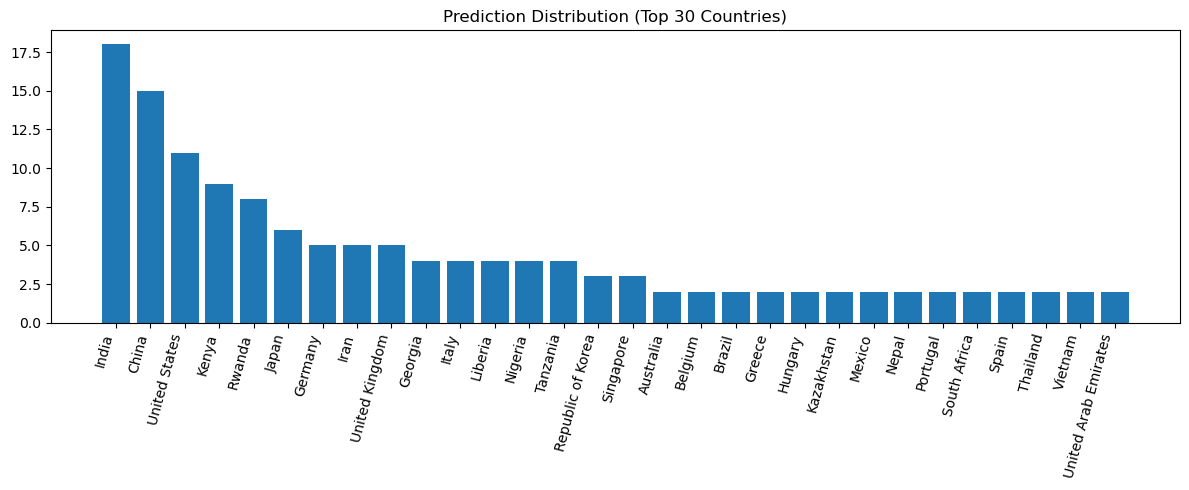

In [16]:
pred_counts = Counter(pred_country_list)
countries, counts = zip(*pred_counts.most_common(30))

plt.figure(figsize=(12,5))
plt.bar(countries, counts)
plt.xticks(rotation=75, ha="right")
plt.title("Prediction Distribution (Top 30 Countries)")
plt.tight_layout()
plt.show()
